In [1]:
#from https://github.com/jfpuget/DSB_2018/blob/master/keras_unet_67_final_save.ipynb

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label, binary_erosion, binary_dilation, disk
from skimage.morphology import square, watershed, closing, binary_closing
from skimage.morphology import remove_small_holes, remove_small_objects
from skimage.filters.rank import gradient
from skimage.exposure import rescale_intensity
from skimage.segmentation import random_walker

from sklearn.model_selection import KFold

from scipy.ndimage.morphology import binary_fill_holes

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam

import tensorflow as tf

import pickle as pkl
import gc

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage2_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import cv2

In [4]:
import random as rn
def init_seeds(seed):
    os.environ['PYTHONHASHSEED'] = '0'

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.

    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.

    rn.seed(seed)

    # Force TensorFlow to use single thread.
    # Multiple threads are a potential source of
    # non-reproducible results.
    # For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

    from keras import backend as K

    # The below tf.set_random_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

    tf.set_random_seed(seed)

    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    return sess

In [5]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

np.random.seed(0)
perm = np.random.permutation(len(train_ids))
train_ids = [train_ids[i] for i in perm]

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [6]:
train = []
train_mask = []


for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    file = "stage1_train/{}/images/{}.png".format(id_,id_)
    mfile = "stage1_train/{}/masks/*.png".format(id_)
    image = cv2.imread(file)
    image = rescale_intensity(image, out_range=np.uint8)
    masks = imread_collection(mfile).concatenate()
    train.append(image)
    train_mask.append(masks)
 

100%|██████████| 664/664 [00:56<00:00, 11.83it/s]


In [7]:
test = [] 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    file = "stage2_test/{}/images/{}.png".format(id_,id_)
    image = cv2.imread(file)
    image = rescale_intensity(image, out_range=np.uint8)
    test.append((image))
    

100%|██████████| 3019/3019 [00:30<00:00, 99.08it/s] 


In [8]:
#Otsu thresholding

def to_flip(img_rgb):
    # do not flip colored images
    if (img_rgb[:,:,0] != img_rgb[:,:,1]).any():
        return img_rgb
    #green channel happends to produce slightly better results
    #than the grayscale image and other channels
    img_gray=img_rgb[:,:,1]#cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_open=cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if (np.sum(img_th==255)>np.sum(img_th==0)):
        return img_rgb
    else:
        return 255 - img_rgb

In [9]:
train = [to_flip(img_rgb) for img_rgb in train]

In [10]:
test = [to_flip(img_rgb) for img_rgb in test]

In [11]:
def split_aux(img):
    height = img.shape[0]
    width = img.shape[1]
    if height > 2*width:
        half = int(height//2)
        return [img[:half, :, :], img[half:, :, :]]
    elif height > width:
        return [img[:width, :, :], img[height-width:, :, :]]
    elif width > 2*height:
        half = int(width//2)
        return [img[:, :half, :], img[:, half:, :]]
    else:
        return [img[:, :height, :], img[:, width-height:, :]]

def split(img):
    s = split_aux(img)
    return s

def split_mask_aux(img):
    height = img.shape[1]
    width = img.shape[2]
    if height > 2*width:
        half = int(height//2)
        return [img[:, :half, :], img[:, half:, :]]
    elif height > width:
        return [img[:, :width, :], img[:, height-width:, :]]
    elif width > 2*height:
        half = int(width//2)
        return [img[:, :, :half], img[:, :, half:]]
    else:
        return [img[:, :, :height], img[:, :, width-height:]]

def split_mask(img):
    s = split_mask_aux(img)
    return s

In [12]:
train_split = [split(img) for img in train]
train_split = [t_split[i] for t_split in train_split for i in [0, 1] ]

train_mask_split = [split_mask(img) for img in train_mask]
train_mask_split = [t_split[i] for t_split in train_mask_split for i in [0, 1] ]

In [13]:
test_split = [split(img) for img in test]
test_split = [t_split[i] for t_split in test_split for i in [0, 1] ]

In [14]:
# Get and resize train images and masks
X_train = np.zeros((len(train_split) * 4, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), np.uint8)
Y_train = np.zeros((len(train_split) * 4, IMG_HEIGHT, IMG_WIDTH, 1), np.uint8)
Z_train = np.zeros((len(train_split) * 4, IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, (img, masks) in enumerate(zip(tqdm(train_split), train_mask_split)):
    img = img[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img_mean = np.mean(img, axis=2).astype(np.uint8)
    for c in range(IMG_CHANNELS):
        img[:,:,c] = img_mean
    X_train[n * 4 + 0] = img
    X_train[n * 4 + 1] = np.fliplr(img)
    X_train[n * 4 + 2] = np.flipud(img)
    X_train[n * 4 + 3] = np.flipud(np.fliplr(img))

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    for mask_id in range(masks.shape[0]):
        mask_ = masks[mask_id, :, :]
        mask_ = mask_ // 255
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                       preserve_range=True).astype(np.uint8)
        mask = np.maximum(mask, mask_)
        mask_lr = np.maximum(mask_lr, np.fliplr(mask_))
        mask_ud = np.maximum(mask_ud, np.flipud(mask_))
        mask_lr_ud = np.maximum(mask_lr_ud, np.flipud(np.fliplr(mask_)))
        
    Y_train[4*n + 0, :, :, 0] = mask
    Y_train[4*n + 1, :, :, 0] = mask_lr
    Y_train[4*n + 2, :, :, 0] = mask_ud
    Y_train[4*n + 3, :, :, 0] = mask_lr_ud
  
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    mask_lr_ud = np.zeros((IMG_HEIGHT, IMG_WIDTH), np.uint8)
    for mask_id in range(masks.shape[0]):
        mask_ = masks[mask_id, :, :]
        mask_ = mask_ // 255
        mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                       preserve_range=True).astype(np.uint8)
        mask_ = binary_dilation(mask_, selem=square(3))
        mask += mask_
        mask_lr += np.fliplr(mask_)
        mask_ud += np.flipud(mask_)
        mask_lr_ud += np.flipud(np.fliplr(mask_))
        
    Z_train[4*n + 0, :, :, 0] = (mask > 1)
    Z_train[4*n + 1, :, :, 0] = (mask_lr > 1)
    Z_train[4*n + 2, :, :, 0] = (mask_ud > 1)
    Z_train[4*n + 3, :, :, 0] = (mask_lr_ud > 1)


Getting and resizing train images and masks ... 


100%|██████████| 1328/1328 [09:06<00:00,  2.43it/s]


In [15]:
for i in tqdm(range(len(train_split) * 4)):
    Z_train[i, :, :, 1] = Y_train[i, :, :, 0]
    Z_train[i, :, :, 2] = np.where(Z_train[i, :, :, 0] == 1, 0, 1 - Y_train[i, :, :, 0])

100%|██████████| 5312/5312 [00:01<00:00, 4561.96it/s]


In [16]:
# Get and resize test images and masks
X_test = np.zeros((len(test_split) * 4, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), np.uint8)
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, img in enumerate(tqdm(test_split)):
    img = img[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    img_mean = np.mean(img, axis=2).astype(np.uint8)
    for c in range(IMG_CHANNELS):
        img[:,:,c] = img_mean
    X_test[n * 4 + 0] = img
    X_test[n * 4 + 1] = np.fliplr(img)
    X_test[n * 4 + 2] = np.flipud(img)
    X_test[n * 4 + 3] = np.flipud(np.fliplr(img))    

Getting and resizing test images ... 


100%|██████████| 6038/6038 [01:06<00:00, 91.18it/s]


Let's see if things look all right by drawing some random images and their associated masks.

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


23 (256, 256, 3)


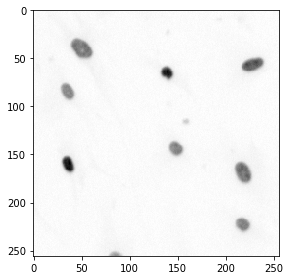

184 (256, 256, 3)


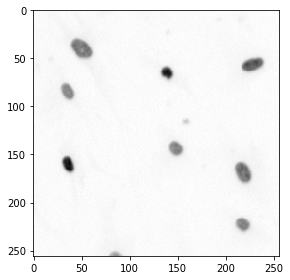

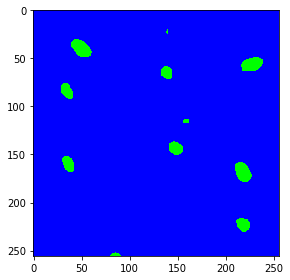

185 (256, 256, 3)


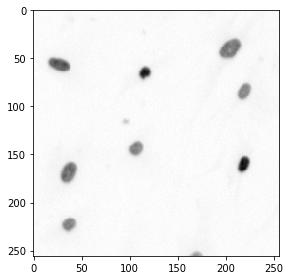

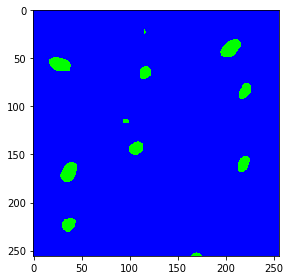

In [17]:
# Check if training data looks all right
ix = 23#random.randint(0, len(train_ids))
print(ix, train[ix].shape)
imshow(train[ix])
plt.show()

for i in range(8*ix, 8*ix + 2):
    print(i, X_train[i].shape)
    imshow(X_train[i])
    plt.show()
    imshow(255*Z_train[i])
    plt.show()

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [17]:
import keras.backend as K

def pixelwise_crossentropy(target, output):
    _epsilon = 10e-8
    output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
    weight = 30 * target[:,:,:,0:1] + 3 * target[:,:,:,1:2] + 1 * target[:,:,:,2:3]
    return - tf.reduce_sum(target * weight *  tf.log(output) +
                           (1 - target)  *  tf.log(1 - output),
                           len(output.get_shape()) - 1)


In [19]:
from keras.engine import Layer
from keras import backend as K

class SpeckleNoise(Layer):
    """Apply multiplicative one-centered Gaussian noise.
    This is useful to mitigate overfitting
    (you could see it as a form of random data augmentation).
    Speckle Noise (GS) is a natural choice as corruption process
    for real valued inputs.
    As it is a regularization layer, it is only active at training time.
    # Arguments
        stddev: float, standard deviation of the noise distribution.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    """

#    @interfaces.legacy_specklenoise_support
    def __init__(self, stddev, **kwargs):
        super(SpeckleNoise, self).__init__(**kwargs)
        self.supports_masking = True
        self.stddev = stddev

    def call(self, inputs, training=None):
        def noised():
            return K.clip(inputs * K.random_normal(shape=K.shape(inputs),
                                            mean=1.,
                                            stddev=self.stddev), 0.0, 1.0)
        return K.in_train_phase(noised, inputs, training=training)

    def get_config(self):
        config = {'stddev': self.stddev}
        base_config = super(SpeckleNoise, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
    
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [20]:
#from https://github.com/zizhaozhang/unet-tensorflow-keras/blob/master/model.py

from keras import layers

#def model(verbose=None):
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))

s = Lambda(lambda x: x/255)(inputs)

conv_a0 = layers.Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
conv_a0 = Dropout(0.1)(conv_a0)
conv_a0 = layers.Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv_a0)
poola0 = layers.MaxPooling2D((2, 2)) (conv_a0)

conv_a = layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (poola0)
conv_a = Dropout(0.1)(conv_a)
conv_a = layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv_a)
pool0 = layers.MaxPooling2D((2, 2)) (conv_a)

conv1 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool0)
conv1 = Dropout(0.1)(conv1)
conv1 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer ='he_normal', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv3)
pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool3)
conv4 = Dropout(0.3)(conv4)
conv4 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv4)
pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = layers.Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool4)
conv5 = Dropout(0.3)(conv5)
conv5 = layers.Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv5)

up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up6, conv4])
conv6 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up6)
conv6 = Dropout(0.3)(conv6)
conv6 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv6)

up7 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv6)
up7 = concatenate([up7, conv3]) 
conv7 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up7)
conv7 = Dropout(0.2)(conv7)
conv7 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv7)

up8 = Conv2DTranspose(64, (2,2), strides = (2,2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up8)
conv8 = Dropout(0.2)(conv8)
conv8 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv8)

up9 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv8)
up9 = layers.concatenate([up9, conv1])
conv9 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up9)
conv9 = Dropout(0.1)(conv9)
conv9 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv9)

up10 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(conv9)
up10 = layers.concatenate([up10, conv_a])
conv10 = layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up10)
conv10 = Dropout(0.1)(conv10)
conv10 = layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer = 'he_normal', padding='same')(conv10)

conv_a0 = layers.Conv2DTranspose(8, (2, 2), strides=(2,2), padding='same') (conv10)
conv_a0 = Dropout(0.1)(conv_a0)
conv_a0 = layers.Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv_a0)
poola0 = layers.MaxPooling2D((2, 2)) (conv_a0)

conv12 = layers.Conv2D(3, (1, 1), activation='sigmoid')(conv10)

model = Model(inputs=[inputs], outputs=[conv12])
model.compile(optimizer=Adam(clipvalue=5), loss=pixelwise_crossentropy)

*Update: Changed to ELU units, added dropout.*

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway). I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters. 

*Update: Added early stopping and checkpointing and increased to 30 epochs.*

In [18]:
from keras.layers.core import Layer
from keras.engine import InputSpec
from keras import backend as K
try:
    from keras import initializations
except ImportError:
    from keras import initializers as initializations

class Scale(Layer):
    '''Learns a set of weights and biases used for scaling the input data.
    the output consists simply in an element-wise multiplication of the input
    and a sum of a set of constants:
        out = in * gamma + beta,
    where 'gamma' and 'beta' are the weights and biases larned.
    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
        
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 Numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
        beta_init: name of initialization function for shift parameter
            (see [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_init: name of initialization function for scale parameter (see
            [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
    '''
    def __init__(self, weights=None, axis=-1, momentum = 0.9, beta_init='zero', gamma_init='one', **kwargs):
        self.momentum = momentum
        self.axis = axis
        self.beta_init = initializations.get(beta_init)
        self.gamma_init = initializations.get(gamma_init)
        self.initial_weights = weights
        super(Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (int(input_shape[self.axis]),)

        # Compatibility with TensorFlow >= 1.0.0
        self.gamma = K.variable(self.gamma_init(shape), name='{}_gamma'.format(self.name))
        self.beta = K.variable(self.beta_init(shape), name='{}_beta'.format(self.name))
        #self.gamma = self.gamma_init(shape, name='{}_gamma'.format(self.name))
        #self.beta = self.beta_init(shape, name='{}_beta'.format(self.name))
        self.trainable_weights = [self.gamma, self.beta]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        out = K.reshape(self.gamma, broadcast_shape) * x + K.reshape(self.beta, broadcast_shape)
        return out

    def get_config(self):
        config = {"momentum": self.momentum, "axis": self.axis}
        base_config = super(Scale, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import layers

from sklearn.metrics import log_loss

bn_axis = 3

import sys
sys.setrecursionlimit(3000)

def identity_block(input_tensor, kernel_size, filters, stage, block):
    '''The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    '''
    eps = 1.1e-5
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    scale_name_base = 'scale' + str(stage) + block + '_branch'

    x = layers.Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a', bias=False)(input_tensor)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2a')(x)
    x = Activation('elu', name=conv_name_base + '2a_relu')(x)

    x = ZeroPadding2D((1, 1), name=conv_name_base + '2b_zeropadding')(x)
    x = layers.Conv2D(nb_filter2, kernel_size, kernel_size,
                      name=conv_name_base + '2b', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2b')(x)
    x = Activation('elu', name=conv_name_base + '2b_relu')(x)

    x = layers.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2c')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2c')(x)

    x = merge([x, input_tensor], mode='sum', name='res' + str(stage) + block)
    x = Activation('elu', name='res' + str(stage) + block + '_relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    '''conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    '''
    eps = 1.1e-5
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    scale_name_base = 'scale' + str(stage) + block + '_branch'

    x = layers.Conv2D(nb_filter1, (1, 1), subsample=strides,
                      name=conv_name_base + '2a', bias=False)(input_tensor)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2a')(x)
    x = Activation('elu', name=conv_name_base + '2a_relu')(x)

    x = ZeroPadding2D((1, 1), name=conv_name_base + '2b_zeropadding')(x)
    x = layers.Conv2D(nb_filter2, kernel_size, kernel_size,
                      name=conv_name_base + '2b', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2b')(x)
    x = Activation('elu', name=conv_name_base + '2b_relu')(x)

    x = layers.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '2c')(x)
    x = Scale(axis=bn_axis, name=scale_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, (1, 1), subsample=strides,
                             name=conv_name_base + '1', bias=False)(input_tensor)
    shortcut = BatchNormalization(epsilon=eps, axis=bn_axis, name=bn_name_base + '1')(shortcut)
    shortcut = Scale(axis=bn_axis, name=scale_name_base + '1')(shortcut)

    x = merge([x, shortcut], mode='sum', name='res' + str(stage) + block)
    x = Activation('elu', name='res' + str(stage) + block + '_relu')(x)
    return x

def resnet152_model(img_rows, img_cols, color_type=1, num_classes=None):
    """
    Resnet 152 Model for Keras
    Model Schema and layer naming follow that of the original Caffe implementation
    https://github.com/KaimingHe/deep-residual-networks
    ImageNet Pretrained Weights 
    Theano: https://drive.google.com/file/d/0Byy2AcGyEVxfZHhUT3lWVWxRN28/view?usp=sharing
    TensorFlow: https://drive.google.com/file/d/0Byy2AcGyEVxfeXExMzNNOHpEODg/view?usp=sharing
    Parameters:
      img_rows, img_cols - resolution of inputs
      channel - 1 for grayscale, 3 for color 
      num_classes - number of class labels for our classification task
    """
    eps = 1.1e-5

    global bn_axis
    img_input = Input(shape=(img_rows, img_cols, color_type), name='data')

    #x = SpeckleNoise(0.01)(img_input)
    x = Lambda(lambda x:x/255)(img_input)
    
    x_a = layers.Conv2D(16,(1,1), activation='elu', kernel_initializer='he_normal', padding='same')(x)
    
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(x)
    x0 = Convolution2D(64, (7, 7), subsample=(2, 2), name='conv1', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=bn_axis, name='bn_conv1')(x0)
    x = Scale(axis=bn_axis, name='scale_conv1')(x)
    x = Activation('elu', name='conv1_relu')(x)
    x = Dropout(0.1)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    x1 = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x1, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    x = Dropout(0.2)(x)

    x2 = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    for i in range(1,8):
        x = identity_block(x2, 3, [128, 128, 512], stage=3, block='b'+str(i))
    x = Dropout(0.3)(x)

    x3 = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    for i in range(1,36):
        x = identity_block(x3, 3, [256, 256, 1024], stage=4, block='b'+str(i))
    x = Dropout(0.3)(x)

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    x = Dropout(0.4)(x)

    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    up6 = concatenate([up6, x3])
    conv6 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv6)

    up7 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv6)
    up7 = concatenate([up7, x2]) 
    conv7 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up7)
    conv7 = Dropout(0.2)(conv7)
    conv7 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv7)

    up8 = Conv2DTranspose(64, (2,2), strides = (2,2), padding='same')(conv7)
    up8 = concatenate([up8, x1])
    conv8 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up8)
    conv8 = Dropout(0.2)(conv8)
    conv8 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv8)

    up9 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv8)
    up9 = layers.concatenate([up9, x0])
    conv9 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up9)
    conv9 = Dropout(0.1)(conv9)
    conv9 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv9)

    up10 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(conv9)
    up10 = layers.concatenate([up10, x_a])
    conv10 = layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(up10)
    conv10 = Dropout(0.1)(conv10)
    conv10 = layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer = 'he_normal', padding='same')(conv10)
    
    x_new = layers.Conv2D(3, (1, 1), activation='sigmoid')(conv10)
    
    model = Model(img_input, x_new)
    
    weights_path = 'resnet152_weights_tf.h5'

    #model.load_weights(weights_path, by_name=True)

    model.compile(optimizer=Adam(clipvalue=5), loss=pixelwise_crossentropy)

    return model

bn_axis = 3
model = resnet152_model(256, 256, 3, 2)
model.summary()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:188: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), name="conv1", strides=(2, 2), use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:139: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), name="res2a_branch2a", strides=(1, 1), use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:146: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="res2a_branch2b", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:151: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res2a_branch2c", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:156: 

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), name="res3b7_branch2b", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (1, 1), name="res3b7_branch2c", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:139: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res4a_branch2a", strides=(2, 2), use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:146: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), name="res4a_branch2b", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:151: Us

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1024, (1, 1), name="res4b11_branch2c", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res4b12_branch2a", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), name="res4b12_branch2b", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1024, (1, 1), name="res4b12_branch2c", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarnin

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res4b24_branch2a", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), name="res4b24_branch2b", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1024, (1, 1), name="res4b24_branch2c", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 1), name="res4b25_branch2a", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:151: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2048, (1, 1), name="res5a_branch2c", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:156: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2048, (1, 1), name="res5a_branch1", strides=(2, 2), use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (1, 1), name="res5b_branch2a", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), name="res5b_branch2b", use_bias=False)`
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:113: Use

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           data[0][0]                       
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, 262, 262, 3)  0           lambda_1[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
bn_conv1 (

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_valid, z_train, z_valid = train_test_split(X_train, Z_train, test_size=0.1, random_state=8011)

In [20]:
from keras.preprocessing.image import ImageDataGenerator



data_gen_args = dict(horizontal_flip=False,
                         vertical_flip=False,
                         rotation_range=90.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.1)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
image_datagen.fit(x_train, seed=7)
mask_datagen.fit(z_train, seed=7)
image_generator = image_datagen.flow(x_train, batch_size=16, seed=7)
mask_generator = mask_datagen.flow(z_train, batch_size=16, seed=7)
train_generator = zip(image_generator, mask_generator)

val_gen_args = dict()
image_datagen_val = ImageDataGenerator(**val_gen_args)
mask_datagen_val = ImageDataGenerator(**val_gen_args)
image_datagen_val.fit(x_valid, seed=7)
mask_datagen_val.fit(z_valid, seed=7)
image_generator_val = image_datagen_val.flow(x_valid, batch_size=16, seed=7)
mask_generator_val = mask_datagen_val.flow(z_valid, batch_size=16, seed=7)
valid_generator=zip(image_generator_val, mask_generator_val)

earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint('unet-enhanced.h5', 
                                   verbose=1, save_best_only=True)
model.fit_generator(train_generator, steps_per_epoch=len(x_train)/16, epochs=30,
                    validation_data=valid_generator, validation_steps=len(x_valid)/16,
                   callbacks=[earlystopper, checkpointer])

Epoch 1/30
299/298 [==============================] - 249s 832ms/step - loss: 0.4445 - val_loss: 0.4254

Epoch 00001: val_loss improved from inf to 0.42540, saving model to unet-enhanced.h5
Epoch 2/30
299/298 [==============================] - 222s 741ms/step - loss: 0.3432 - val_loss: 0.5523

Epoch 00002: val_loss did not improve from 0.42540
Epoch 3/30
299/298 [==============================] - 221s 741ms/step - loss: 0.3189 - val_loss: 0.9474

Epoch 00003: val_loss did not improve from 0.42540
Epoch 4/30
299/298 [==============================] - 221s 740ms/step - loss: 0.3435 - val_loss: 0.7901

Epoch 00004: val_loss did not improve from 0.42540
Epoch 5/30
299/298 [==============================] - 221s 740ms/step - loss: 0.3133 - val_loss: 0.9692

Epoch 00005: val_loss did not improve from 0.42540
Epoch 6/30
299/298 [==============================] - 221s 740ms/step - loss: 0.2969 - val_loss: 0.5848

Epoch 00006: val_loss did not improve from 0.42540
Epoch 7/30
299/298 [==========

In [25]:
"""
try:
    sess.close()
except:
    pass

sess = init_seeds(0)

# even number of folds because we duplicate images
kf = KFold(6, shuffle=False)

models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print('*' * 40)
    print('Fold:', fold)
    X_train_kf = X_train[train_idx]
    X_val_kf = X_train[val_idx]
    Z_train_kf = Z_train[train_idx]
    Z_val_kf = Z_train[val_idx]

    model = model(verbose=(fold==0))
    models.append(model)

    # Fit model
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint('model_%s_%d.h5' % (fname, fold), 
                                   verbose=1, save_best_only=True)
    results = model.fit(X_train_kf, Z_train_kf, 
                        validation_data = (X_val_kf, Z_val_kf), epochs=30,
                        batch_size=8, shuffle=True,
                        callbacks=[earlystopper, checkpointer])

#sess.close()
"""


"\ntry:\n    sess.close()\nexcept:\n    pass\n\nsess = init_seeds(0)\n\n# even number of folds because we duplicate images\nkf = KFold(6, shuffle=False)\n\nmodels = []\n\nfor fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):\n    print('*' * 40)\n    print('Fold:', fold)\n    X_train_kf = X_train[train_idx]\n    X_val_kf = X_train[val_idx]\n    Z_train_kf = Z_train[train_idx]\n    Z_val_kf = Z_train[val_idx]\n\n    model = model(verbose=(fold==0))\n    models.append(model)\n\n    # Fit model\n    earlystopper = EarlyStopping(patience=5, verbose=1)\n    checkpointer = ModelCheckpoint('model_%s_%d.h5' % (fname, fold), \n                                   verbose=1, save_best_only=True)\n    results = model.fit(X_train_kf, Z_train_kf, \n                        validation_data = (X_val_kf, Z_val_kf), epochs=30,\n                        batch_size=8, shuffle=True,\n                        callbacks=[earlystopper, checkpointer])\n\n#sess.close()\n"

All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [21]:
try:
    sess.close()
except:
    pass

sess = init_seeds(0)

In [22]:
"""
preds_train = np.zeros(Z_train.shape)
preds_test = 0
# Predict on train, val and test
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    model = load_model('model_%s_%d.h5' % (fname, fold), 
                       custom_objects={'pixelwise_crossentropy':pixelwise_crossentropy,
                                       'SpeckleNoise':SpeckleNoise,
                                      })
    X_val_kf = X_train[val_idx]
    preds_train[val_idx] = model.predict(X_val_kf, verbose=1)
    preds_test += model.predict(X_test, verbose=1)
preds_test /= 6
"""

"\npreds_train = np.zeros(Z_train.shape)\npreds_test = 0\n# Predict on train, val and test\nfor fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):\n    model = load_model('model_%s_%d.h5' % (fname, fold), \n                       custom_objects={'pixelwise_crossentropy':pixelwise_crossentropy,\n                                       'SpeckleNoise':SpeckleNoise,\n                                      })\n    X_val_kf = X_train[val_idx]\n    preds_train[val_idx] = model.predict(X_val_kf, verbose=1)\n    preds_test += model.predict(X_test, verbose=1)\npreds_test /= 6\n"

In [33]:
model = load_model('unet-enhanced.h5', 
                       custom_objects={'pixelwise_crossentropy':pixelwise_crossentropy, 'Scale':Scale})

preds_test = model.predict(X_test, verbose=1)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


24152/24152 [==============================] - 310s 13ms/step


In [34]:
def merge(img1, img2, shape):
    ov2 = 5
    height = shape[0]
    width = shape[1]
    img = np.zeros((height, width, 3), dtype=np.float32)
    w = np.zeros((height, width, 1), dtype=np.float32)
    height1 = img1.shape[0]
    width1 = img1.shape[1]
    height2 = img2.shape[0]
    width2 = img2.shape[1]  
    w1 = 10*ov2*np.ones((height1, width1, 1), dtype=np.float32)
    w2 =  10*ov2*np.ones((height2, width2, 1), dtype=np.float32)
    for i in range(ov2, 0, -1):
        w1[i-1,:] = 10*i
        w1[height1 - i, :] = 10*i
        w1[:, i-1] = 10*i
        w1[:, width1 - i] = 10*i
        w2[i-1,:] = 10*i
        w2[height2 - i, :] = 10*i
        w2[:, i-1] = 10*i
        w2[:, width2 - i] = 10*i

    if height > 2*width:
        half = int(height//2)
        img[:half, :, :] += w1*img1
        img[half:, :, :] += w2*img2
        w[:half, :] += w1
        w[half:, :] += w2
        img /= w
    elif height > width:
        img[:width, :, :] += w1*img1
        img[height-width:, :, :] += w2*img2
        w[:width, :] += w1
        w[height-width:, :] += w2
        img /= w
    elif width > 2*height:
        half = int(width//2)
        img[:, :half, :] += w1*img1
        img[:, half:, :] += w2*img2
        w[:, :half] += w1
        w[:, half:] += w2
        img /= w
    else:
        img[:, :height, :] += w1*img1 
        img[:, width-height:, :] += w2*img2
        w[:, :height] += w1 
        w[:, width-height:] += w1
        img /= w
    return (255*img).astype(np.uint8)

In [35]:
preds_test_upsampled = []
for i in tqdm(range(len(test_split))):
    test_i = test_split[i]
    pred = resize(np.squeeze(preds_test[4*i + 0]), 
                  (test_i.shape[0], test_i.shape[1]), 
                  mode='constant', preserve_range=True)
    pred += np.fliplr(resize(np.squeeze(preds_test[4*i + 1]), 
                  (test_i.shape[0], test_i.shape[1]), 
                  mode='constant', preserve_range=True))
    pred += np.flipud(resize(np.squeeze(preds_test[4*i + 2]), 
                  (test_i.shape[0], test_i.shape[1]), 
                  mode='constant', preserve_range=True))
    pred += np.flipud(np.fliplr(resize(np.squeeze(preds_test[4*i + 3]), 
                  (test_i.shape[0], test_i.shape[1]), 
                  mode='constant', preserve_range=True)))
    #pred = (pred > 4*threshold).astype(np.uint8)
    pred /= 4
    preds_test_upsampled.append(pred)


100%|██████████| 6038/6038 [06:40<00:00, 15.08it/s]


In [36]:
preds_test_merged = []
for ix in tqdm(range(len(test))):    
    merged = merge(preds_test_upsampled[2*ix+0], 
                 preds_test_upsampled[2*ix+1],
                 test[ix].shape
            )
    preds_test_merged.append(merged)

100%|██████████| 3019/3019 [00:22<00:00, 132.51it/s]


In [37]:

def get_labels(y):
    labels = np.zeros((y.shape[1], y.shape[2]))
    for i in range(y.shape[0]):
        labels = np.where(y[i,:,:] > 0, i+1, labels)
    return labels

def iou_score_cuk(y_true, y_pred, verbose=True, thresholds=np.arange(0.5, 1.0, 0.05)):
    y_true = get_labels(y_true)
    y_pred = get_labels(y_pred)
    # Compute number of objects
    true_objects = len(np.unique(y_true))
    pred_objects = len(np.unique(y_pred))
    if verbose:
        print("Number of true objects:", true_objects - 1)
        print("Number of predicted objects:", pred_objects - 1)
    
    intersection = np.histogram2d(y_true.flatten(), y_pred.flatten(), 
                                  bins=(true_objects, pred_objects))[0].astype('int')

    area_true = np.histogram(y_true, bins = true_objects)[0]
    area_true = np.expand_dims(area_true, -1)

    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_pred = np.expand_dims(area_pred, 0)

    union = area_true + area_pred - intersection
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9
    
    iou = intersection / union
    
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn    
    
    prec = []
    
    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in thresholds:
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) == 0:
            p = 1
        else:
            p = tp / (tp + fp + fn)
        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

from skimage.morphology import label



In [38]:
from scipy.ndimage.morphology import binary_fill_holes

def get_pred_watershed(upsampled, area_threshold, threshold, sep_threshold, 
             spread_threshold, alpha, connectivity=2):
    img = ((upsampled[:,:,1] > 255 * threshold) &
                    (upsampled[:,:,0] < 255 * sep_threshold))
    img = binary_fill_holes(img)
    img = remove_small_objects(img, area_threshold)
    lab_img = label(img, connectivity=connectivity)
    distance = upsampled[:,:,1] + alpha * upsampled[:,:,0]
    img = 1 * ((distance > 255 * spread_threshold) )
    
    lab_img = img * watershed(- upsampled[:,:,1], lab_img)

    y_pred = np.zeros((lab_img.max(), lab_img.shape[0], lab_img.shape[1]), np.uint16)
    i = 0
    for lab in range(lab_img.max()):
        tmp = (lab_img == lab+1)
        if np.sum(tmp.ravel()) > area_threshold:
            y_pred[i,:,:] = tmp
            i += 1
    return y_pred[:i]

from scipy.ndimage.morphology import binary_fill_holes

def get_pred_random_walker(upsampled, area_threshold, threshold, sep_threshold, 
             spread_threshold, alpha, connectivity=2):
    img = ((upsampled[:,:,1] > 255 * threshold) &
                    (upsampled[:,:,0] < 255 * sep_threshold))
    
    img = binary_fill_holes(img)
    img = remove_small_objects(img, area_threshold)
    markers = label(img, connectivity=connectivity)
    distance = upsampled[:,:,1] + alpha * upsampled[:,:,0]
    mask = ((distance > 255 * spread_threshold) )
    markers[~mask] = -1
    
    lab_img = random_walker(mask, markers)

    y_pred = np.zeros((lab_img.max(), lab_img.shape[0], lab_img.shape[1]), np.uint16)
    i = 0
    for lab in range(lab_img.max()):
        tmp = (lab_img == lab+1)
        if np.sum(tmp.ravel()) > area_threshold:
            y_pred[i,:,:] = tmp
            i += 1
    return y_pred[:i]

def get_pred(upsampled, area_threshold, threshold, sep_threshold, 
             spread_threshold, alpha, connectivity=2):
    try:
        return get_pred_random_walker(upsampled, area_threshold, threshold, 
                                          sep_threshold, spread_threshold, 
                                      alpha, connectivity)
    except:
        return get_pred_watershed(upsampled, area_threshold, threshold, 
                                          sep_threshold, spread_threshold, 
                                      alpha, connectivity)
        

In [39]:
area_threshold = 20
threshold = 0.75
sep_threshold = 0.6
spread_threshold = 0.4
alpha=0.4

def get_pred(upsampled, area_threshold=area_threshold, 
             threshold=threshold, sep_threshold=sep_threshold, 
             spread_threshold=spread_threshold, alpha=alpha, connectivity=2):
    try:
        return get_pred_random_walker(upsampled, area_threshold, threshold, 
                                          sep_threshold, spread_threshold, 
                                      alpha, connectivity=2)
    except:
        return get_pred_watershed(upsampled, area_threshold, threshold, 
                                          sep_threshold, spread_threshold, 
                                      alpha, connectivity=2)

In [40]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths
            
def pred_to_rles(y_pred):
    for i in range(y_pred.shape[0]):
        tmp = y_pred[i]
        yield rle_encoding(tmp)


In [41]:
new_test_ids = []
rles = []
for n, id_ in tqdm(enumerate(test_ids)):
    y_pred = get_pred(preds_test_merged[n])
    rle = list(pred_to_rles(y_pred))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

print(len(rles))

# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('keras_unet_test.csv', index=False)

57it [00:15,  3.70it/s]/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/segmentation/random_walker_segmentation.py:91: RuntimeWarning: divide by zero encountered in double_scalars
  beta /= 10 * data.std()
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/segmentation/random_walker_segmentation.py:96: RuntimeWarning: invalid value encountered in multiply
  gradients *= beta
3019it [18:16,  2.75it/s]


103106
